<!-- # TODO: Title -->

# Dog breed classification

<!-- This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code. -->

<!-- **TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional. -->

In this notebook:

1. The dataset of dog breeds is collected and uploaded to an S3 bucket.
1. A pre-trained model is fine-tuned on the dataset, on AWS SageMaker
1. First the model undergoes hyperparameter tuning,
1. Then, selecting the most appropriate hyperparameters, the model is trained,
   & profiled, and debugged.
1. Once the training is complete the model is deployed to an endpoint, and
   queried.
1. _and in the end, all AWS resources are released_

<!-- **Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks. -->


In [2]:
# DONE: TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install -U pip > /dev/null 2> /dev/null
!pip install -U awscli boto3 sagemaker smdebug > /dev/null


In [50]:
# DONE: TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import random
from pathlib import Path

import boto3
import IPython
import matplotlib.pyplot as plt
import sagemaker
from PIL import Image
from sagemaker.debugger import (
    DebuggerHookConfig,
    FrameworkProfile,
    ProfilerConfig,
    ProfilerRule,
    Rule,
    rule_configs,
)
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)
from smdebug.core.modes import ModeKeys
from smdebug.trials import create_trial
from torchvision import transforms


In [75]:
random.seed(42)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16, 9)
# instance_type_train = "ml.m5.large"
instance_type_train = "ml.g4dn.xlarge"
# instance_type_deploy = "ml.m3.medium"
instance_type_deploy = "ml.m4.xlarge"
role = sagemaker.get_execution_role()


## Dataset

<!-- TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it. -->

The dataset consists of images of several dog breeds, split into train, test, &
validation.


In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null


--2023-03-31 11:39:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.0
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  16.3MB/s    in 32s     

2023-03-31 11:40:20 (33.6 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = "dogImages"
inputs_train = session.upload_data(
    path="./dogImages/train",
    bucket=bucket,
    key_prefix=os.path.join(prefix, "train"),
)
inputs_test = session.upload_data(
    path="./dogImages/test",
    bucket=bucket,
    key_prefix=os.path.join(prefix, "test"),
)
inputs_valid = session.upload_data(
    path="./dogImages/valid",
    bucket=bucket,
    key_prefix=os.path.join(prefix, "test"),
)


## Hyperparameter Tuning

<!-- **TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges. -->

<!-- **Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning. -->


In [7]:
# DONE: TODO: Declare your HP ranges, metrics etc.
hp_ranges = {
    "epochs": IntegerParameter(2, 16),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "lr": ContinuousParameter(0.001, 0.1),
    "beta1": ContinuousParameter(0.03, 0.9),
    "beta2": ContinuousParameter(0.03, 0.999),
}


In [8]:
objective_metric_name = "mean loss"
objective_type = "Minimize"
metric_definitions = [
    {
        "Name": "mean loss",
#         "Regex": r"(?i)(?<=^average\sloss:\s)([\d\.]+)",
        "Regex": r"Average loss: ([0-9\.]+)",
    }
]


In [9]:
# DONE: TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py39",
    framework_version="1.13.1",
    instance_count=1,
    instance_type=instance_type_train,
)  # DONE: TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hp_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)  # DONE: TODO: Your HP tuner here


In [10]:
# TODO: Fit your HP Tuner
_ = tuner.fit(
    {"training": inputs_train, "validation": inputs_valid},
)  # TODO: Remember to include your data channels


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230331-1152


..........................................................................................................................................................................................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()  # TODO

# Get the hyperparameters of the best trained model
hyperparameters = best_estimator.hyperparameters()
hyperparameters



2023-03-31 12:18:01 Starting - Preparing the instances for training
2023-03-31 12:18:01 Downloading - Downloading input data
2023-03-31 12:18:01 Training - Training image download completed. Training in progress.
2023-03-31 12:18:01 Uploading - Uploading generated training model
2023-03-31 12:18:01 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"mean loss"',
 'batch-size': '"128"',
 'beta1': '0.4044972406783016',
 'beta2': '0.9988714149568779',
 'epochs': '11',
 'lr': '0.018375034248230008',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-31-11-52-45-074"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-986549703545/pytorch-training-2023-03-31-11-52-45-074/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

<!-- TODO: Using the best hyperparameters, create and finetune a new model -->

<!-- **Note:** You will need to use the `train_model.py` script to perform model profiling and debugging. -->


In [12]:
# DONE: TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
]


In [13]:
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10),
)


In [32]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version="py39",
    framework_version="1.13.1",
    instance_count=1,
    instance_type=instance_type_train,
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=hook_config,
)  # DONE: TODO: Your estimator here


In [ ]:
_ = estimator.fit(
    {
        "training": inputs_train,
        "validation": inputs_valid,
        "testing": inputs_test,
    },
)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-31-13-31-19-414


2023-03-31 13:31:21 Starting - Starting the training job...
2023-03-31 13:31:35 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
LowGPUUtilization: InProgress
...
2023-03-31 13:32:27 Downloading - Downloading input data......
2023-03-31 13:33:31 Training - Downloading the training image...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-31 13:36:06,475 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-31 13:36:06,497 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-03-31 13:36:06,508 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-31 13:36:06,514 sagemaker_pytorch_container.training INFO     Invoking user traini

In [39]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
tensor_name = random.choice([
    tname
    for tname in trial.tensor_names()
    if "gradient" in tname
])


[2023-03-31 14:13:39.761 pytorch-1-13-gpu-py-ml-g4dn-xlarge-527e33c924f34a0c20ebf51c5b64:23 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-986549703545/pytorch-training-2023-03-31-13-31-19-414/debug-output


In [40]:
def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(step, mode=mode) for step in steps]
    return steps, vals


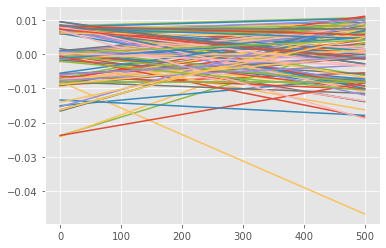

In [43]:
steps_train, vals_train = get_data(trial, tensor_name, ModeKeys.TRAIN)
steps_eval, vals_eval = get_data(trial, tensor_name, ModeKeys.EVAL)

plt.plot(steps_train, vals_train, label=tensor_name)
plt.plot(steps_eval, vals_eval, label=f"val_{tensor_name}")
# plt.legend()
plt.show()


<!-- **TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it? -->


In [71]:
# TODO: Display the profiler output

profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

prefix = os.path.join(
    # estimator.output_path,
    estimator.latest_training_job.job_name,
    "rule-output",
    profiler_report_name,
    "profiler-output/profiler-report.html",
)


In [73]:
session.download_data(
    path=".",
    bucket=bucket,
    key_prefix=prefix
)
IPython.display.HTML(filename="./profiler-report.html")


## Model Deploying


In [76]:
# TODO: Deploy your model to an endpoint

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type_deploy,
)  # TODO: Add your deployment configuration like instance type and number of instances


INFO:sagemaker:Creating model with name: pytorch-training-2023-03-31-14-33-46-879
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-03-31-14-33-46-879
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-31-14-33-46-879


-------!

In [81]:
# TODO: Run an prediction on the endpoint
ROOT = Path(".").resolve()
TEST_DIR = ROOT / "dogImages"/ "test"
img_dir = (
    TEST_DIR
    / random.choice(os.listdir(TEST_DIR))
)
img_path = (
    img_dir
    / random.choice(os.listdir(img_dir))
)

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

image = transform(
    Image.open(img_path)
)  # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)


In [82]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()


INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2023-03-31-14-33-46-879
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2023-03-31-14-33-46-879
